### Imports

In [1]:
import hcl
import data_hcl
import importlib
import mlm
import utils
from time import perf_counter
import seaborn as sns
import ner
import numpy as np
seed=42

E:\APPLIS\Anaconda3\envs\berthelierex\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
os.getcwd()

'E:\\APPLIS\\JupyterHub\\berthelierex\\notebooks'

### Dataset

In [8]:
t1 = perf_counter()
df_train = data_hcl.get_data_df()
df_test = data_hcl.get_data_df(data_type="validation")
df_train = df_train.sample(frac=0.0006,random_state=seed).reset_index(drop=True)
df_test = df_test.sample(frac=0.0018,random_state=seed).reset_index(drop=True)
utils.get_delay(t1)
df_train.head()

--------------------
Done in 4.17 min
 


,text,type,words,unique_words,length,label
0,Date : 21/01/2019; Type cerfa : de prolongatio...,Certificat,135,74,899,12
1,PERRIN MATHIAS né le 26/02/2014 - Fiche de con...,Compte-rendu consultation,213,139,1342,19
2,Surveillance du travail Spécialité : GYNECO-OB...,Mot de suivi,53,36,309,68
3,GROUPEMENT HOSPITALIER NORD Hôpital de la Croi...,Compte-rendu consultation,347,251,2436,19
4,Protocole imagerie IAO Page 1/1 N° téléphone (...,Demande d'examen,239,169,1274,37


Training


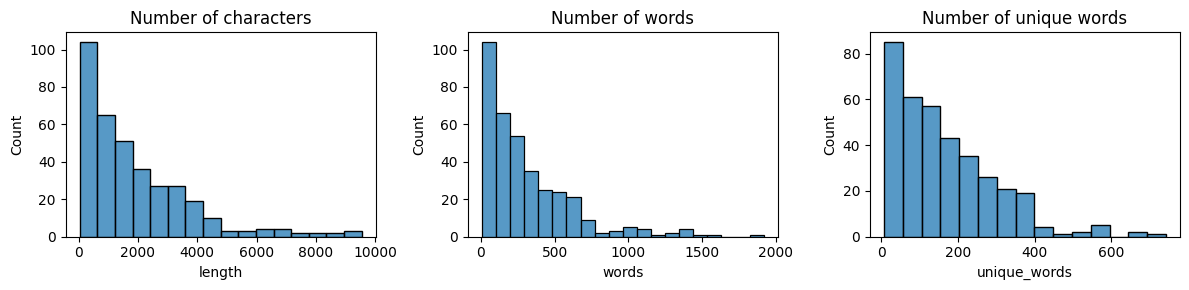

Mean length:  1905.6
Mean number of words:  309.9
Mean number of unique words:  165.5


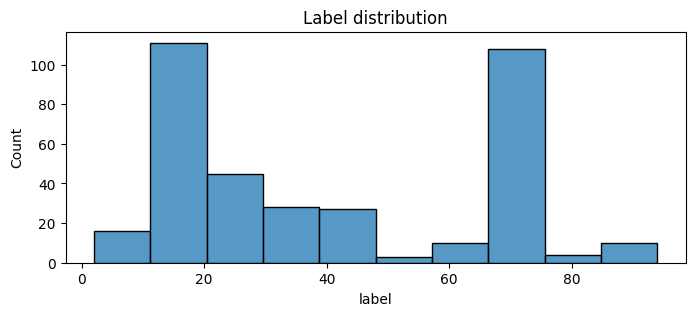

Size :  (362, 6)

Test


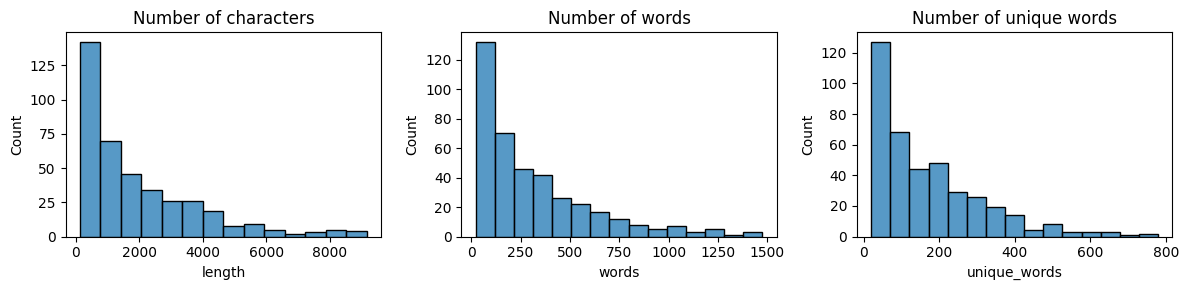

Mean length:  1983.4
Mean number of words:  314.2
Mean number of unique words:  172.5


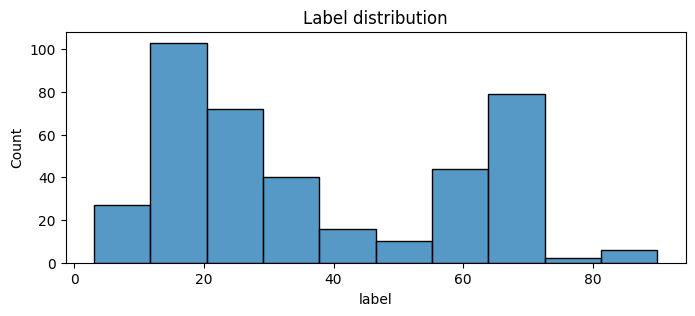

Size :  (399, 6)


In [9]:
print("Training")
hcl.show_df(df_train,label_names=False)
print("Size : ",df_train.shape)
print("")
print("Test")
hcl.show_df(df_test,label_names=False)
print("Size : ",df_test.shape)

In [10]:
tokenizer = data_hcl.get_tokenizer()
model = data_hcl.get_model()
generator = data_hcl.get_generator(tokenizer)

In [11]:
print(generator(["Hospices civils de <mask>"])[0])
print(generator(["Le docteur <mask> travaille aux Hospices civils de Lyon"])[0])
print(generator(["Le docteur SIMON <mask> travaille aux Hospices civils de Lyon"])[0])
print(generator(["Le docteur SIMONNET <mask>"])[0])

{'score': 0.9996626377105713, 'token': 147, 'token_str': 'Lyon', 'sequence': 'Hospices civils de Lyon'}
{'score': 0.02261178195476532, 'token': 3397, 'token_str': 'SIMON', 'sequence': 'Le docteur SIMON travaille aux Hospices civils de Lyon'}
{'score': 0.622911810874939, 'token': 765, 'token_str': 'NET', 'sequence': 'Le docteur SIMONNET travaille aux Hospices civils de Lyon'}
{'score': 0.29831749200820923, 'token': 10, 'token_str': ',', 'sequence': 'Le docteur SIMONNET,'}


In [12]:
dataset_train = hcl.get_label_ds(df_train,tokenizer,seed)
dataset_test = hcl.get_label_ds(df_test,tokenizer,seed)

### MIA

In [13]:
utils.reload(mlm)
utils.reload(ner)
dataset_train = mlm.add_dataset_masks(tokenizer,dataset_train) #1 min
dataset_test = mlm.add_dataset_masks(tokenizer,dataset_test)
print(dataset_train.num_rows)

362


In [14]:
utils.reload(mlm)
t1 = perf_counter()

do_perfs = True

if do_perfs: #145 min train 292 min test
    model0 = data_hcl.get_model("camembert-base")

    print("Computing train")
    perfs_train = mlm.compare_performance(model,model0,dataset_train,tokenizer,mask="<mask>")
    utils.get_delay(t1)
    np.savetxt(f"mia/perfs_train.txt",perfs_train)

    print("Computing test")
    perfs_test = mlm.compare_performance(model,data_hcl.get_model("camembert-base"),dataset_test,tokenizer,mask="<mask>")
    utils.get_delay(t1)
    np.savetxt(f"mia/perfs_test.txt",perfs_test)

Computing train
--------------------
Done in 144.10 min
 
Computing test
--------------------
Done in 291.44 min
 


Training MIA on 316 'in's
Validation on 36 'in's
Training MIA
Predicting
Validation accuracy
--------------------
Done in 0.00 min
 
              precision    recall  f1-score   support

           0       0.60      0.50      0.55        36
           1       0.57      0.67      0.62        36

    accuracy                           0.58        72
   macro avg       0.59      0.58      0.58        72
weighted avg       0.59      0.58      0.58        72

Training accuracy
--------------------
Done in 0.00 min
 
              precision    recall  f1-score   support

           0       0.86      0.74      0.80       316
           1       0.77      0.88      0.82       316

    accuracy                           0.81       632
   macro avg       0.82      0.81      0.81       632
weighted avg       0.82      0.81      0.81       632



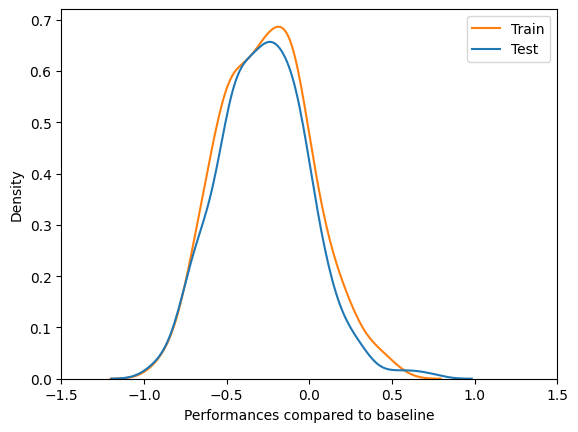

In [45]:
utils.reload(mlm)
model0 = data_hcl.get_model("camembert-base")
true,pred,x = mlm.mia_pipeline(model,model0,dataset_train,dataset_test,tokenizer,"<mask>",seed,"mia",do_perfs=False,simple=False,pos_weight=1.2)

### Data extraction

In [50]:
ner_tokenizer = ner.get_ner_tokenizer()
ner_generator = ner.get_ner_generator(ner_tokenizer)

In [53]:
dataset_train = hcl.get_label_ds(df_train,ner_tokenizer,seed)
dataset_test = hcl.get_label_ds(df_test,ner_tokenizer,seed)

utils.reload(hcl)
dataset_train = hcl.truncate(dataset_train,900)
dataset_test = hcl.truncate(dataset_test,900)
print("Train:",dataset_train.num_rows)
print("Test:",dataset_test.num_rows)

Train: 362
Test: 399


In [54]:
utils.reload(mlm)
utils.reload(ner)
t1 = perf_counter()
dataset_train = mlm.add_private_predictions(ner_generator,ner_tokenizer,dataset_train)
dataset_test = mlm.add_private_predictions(ner_generator,ner_tokenizer,dataset_test)
utils.get_delay(t1)

--------------------
Done in 5.27 min


In [56]:
utils.reload(mlm)

do_extractions = False
if do_extractions:
    print("Train data")
    t1 = perf_counter()
    trues,total,extracted = mlm.private_extraction(generator,dataset_train)
    utils.get_delay(t1)
    print("% private tokens extracted : ",round((trues/total)*100,2))
    print(trues,"/",total)
    np.savetxt("extr/train_extr.txt",extracted)

    print("Test data")
    t1 = perf_counter()
    trues,total,extracted = mlm.private_extraction(generator,dataset_test)
    utils.get_delay(t1)
    print("% private tokens extracted : ",round((trues/total)*100,2))
    print(trues,"/",total)
    np.savetxt("extr/test_extr.txt",extracted)

In [57]:
print("Counterfactual data")
t1 = perf_counter()
trues,total,extracted = mlm.private_extraction(generator,dataset_train.select(counterfactuals))
utils.get_delay(t1)
print("% private tokens extracted : ",round((trues/total)*100,2))
print(trues,"/",total)

Counterfactual data
--------------------
Done in 0.51 min
% private tokens extracted :  15.0
15 / 100
